# Terceiro Trabalho de Introdução à Computação Visual


Arthur Pontes Nader <br>
Luiz Philippe Pereira Amaral <br>
Rita Rezende Borges de Lima

## Instalação de bibliotecas e módulos

In [4]:
!pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


## Pré Processamento


Inicialmente declaramos a função ```char_to_int(x)```, que dado um caracter __x__, retorna seu valor inteiro correspondente.

In [6]:
def char_to_int(x):
    return {"0" : 0, "1" : 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9, \
     "A" : 10, "B" : 11, "C" : 12, "D" : 13, "E" : 14, "F" : 15, "G" : 16, "H" : 17, "I" : 18,        \
     "J" : 19, "K" : 20, "L" : 21, "M" : 22, "N" : 23, "O" : 24, "P" : 25, "Q" : 26, "R" : 27,        \
     "S" : 28, "T" : 29, "U" : 30, "V" : 31, "X" : 32, "W" : 33, "Y" : 34, "Z" : 35, "?": 36}[x]

### Leitura de Dados 

Declaramos uma função ```get_labels()``` que tem como propósito ler um arquivo com o rótulo, e retornar este como uma lista de inteiros, para isso utiliza a função declarada previamente ```char_to_int()```.

In [7]:
def get_labels(idx):

    arq = open("CAPTCHA-10k/labels10k/" + f"{idx:06}" + ".txt", "r")
    line = arq.readline()
    arq.close()
    
    return [char_to_int(char) for char in line if char != "\n"]

### Processamento da Imagem

Em ambas as funções a seguir realizamos o processamento da imagem recebida como parâmetro, em ```image_preprocessing(img_path)``` fazemos a leitura da imagem, convertemos para gray scale, fazemos a binarização e aplicamos um blur com a mediana dos pixeis. De posse dessa imagem a função ```separate_image_characters(img)``` corta a imagem em 6 "pedaços", um para cada caracter e retorna estes em uma lista.

In [8]:
def image_processing(img_path):
    
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bin_img = cv2.threshold(gray_img, 16, 255, cv2.THRESH_BINARY)[1]
    img_median = cv2.medianBlur(bin_img, 5)
    
    return img_median 

def separate_image_characters(img):
    
    characters = []
    
    for j in range(10, img.shape[1], 30):
        aux = img[:,j:j+30]
        aux = cv2.resize(aux,(40,40))
        aux = cv2.threshold(aux, 127, 255, cv2.THRESH_BINARY)[1]
        aux = aux/255
#         aux = aux.flatten()
        characters.append(aux)
        
    return characters

Por fim implementamos o procedimento ```pre_processing(initial_range, final_range, dir_path)``` que para cada um dos arquivos faz sua leitura e chama as funções previamente implementadas e descritas para os conjuntos de dado de treinamento, validação e teste.

In [50]:
def pre_processing(initial_range, final_range, dir_path):

    x, y = [], []
    for i in range(initial_range, final_range):
        
        labels = get_labels(i)
        
        img_path = dir_path + "/" + f"{i:06}" + ".jpg" 
        img = image_processing(img_path)
        img_characters = separate_image_characters(img)
       
        for idx in range(0, 6):
            x.append(img_characters[idx])
            y.append(labels[idx])
            
    return np.array(x, dtype=np.float32), np.array(y).reshape(len(y), 1)

x_train, y_train = pre_processing(1, 8001, 'CAPTCHA-10k/treinamento')
x_val, y_val = pre_processing(8001, 9001, 'CAPTCHA-10k/validacao')
x_test, y_test = pre_processing(9001, 10001, 'CAPTCHA-10k/teste')

Exemplo de dado:

Imagem 40x40


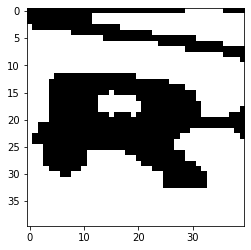

O rótulo é: [27]


In [51]:
num = 0
img = (x_train[num]*255) #.reshape((40,40))
print("Imagem {}x{}".format(len(img), len(img)))
plt.imshow(img, cmap='gray')
plt.show()

print("O rótulo é:", y_train[num])

In [67]:
print(to_categorical(y_test).shape, to_categorical(y_train).shape)

(6000, 36) (48000, 37)


## Definição da Arquitetura

In [68]:
IMG_HEIGHT, IMG_WIDTH = 40, 40
NUMBER_OF_LABELS = 37

# Sequential layer
model = Sequential()

# CNN input layer
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))

# hiden layers
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

# fully connected layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUMBER_OF_LABELS, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 40, 40, 32)        320       
                                                                 
 conv2d_23 (Conv2D)          (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 flatten_11 (Flatten)        (None, 25600)             0         
                                                                 
 dense_21 (Dense)            (None, 64)                1638464   
                                                     

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:

response = model.fit(
            x_train, to_categorical(y = y_train, num_classes = NUMBER_OF_LABELS), 
            validation_data=(x_val, to_categorical(y_val, num_classes = NUMBER_OF_LABELS)),
            batch_size=256, epochs=1, verbose=1)


188/188 [==============================] - 232s 1s/step - loss: 2.5083 - accuracy: 0.2666 - val_loss: 0.9653 - val_accuracy: 0.7845


In [72]:
score = model.evaluate(x_test, to_categorical(y_test), verbose=1)
print(score)

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2329/3954641415.py", line 1, in <cell line: 1>
      score = model.evaluate(x_test, to_categorical(y_test), verbose=1)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/engine/training.py", line 1501, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/keras/backend.py", line 5134, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,37] labels_size=[32,36]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_10781]

In [45]:
print(to_categorical(y_test))
print(y_test.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
(6000,)
